In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, UpSampling2D, ZeroPadding2D, Conv2DTranspose, Reshape, GlobalAveragePooling2D
from keras.optimizers import Adam

from Utils import *

2024-07-10 15:40:29.954220: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 15:40:30.024714: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 15:40:30.025444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 15:40:31.024959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Import Data

In [2]:
# import the .pkl file
df = pd.read_pickle("esc10.pkl")
print('Shape of the dataframe:', df.shape)
print('Shape of a mel spectrogram:', df.mel_spectrogram[0].shape)

Shape of the dataframe: (1600, 4)
Shape of a mel spectrogram: (128, 156)


#### Define AE model

In [3]:
def init_autoencoder():

    model = Sequential()
    # encoder
    model.add(Conv2D(16, kernel_size=(2,3), activation='relu', padding='same', input_shape=(128, 156, 1))) # 128x156 -> 128x156
    model.add(Conv2D(16, kernel_size=(2,3), activation='relu', padding='same')) # 128x156 -> 128x156
    
    model.add(Conv2D(32, kernel_size=(2,3), activation='relu', strides=(2,3))) # 128x156 -> 64x52
    model.add(Conv2D(32, kernel_size=(2,3), activation='relu', padding='same')) # 64x52 -> 64x52

    model.add(Conv2D(64, kernel_size=3, activation='relu', strides=3, padding='same')) # 64x52 -> 22x18
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same')) # 22x18 -> 22x18  

    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # 22x18 -> 11x9

    # decoder
    model.add(UpSampling2D(size=(2,2))) # 11x9 -> 22x18

    model.add(Conv2DTranspose(64, kernel_size=3, activation='relu', padding='same')) # 22x18 -> 22x18
    model.add(Conv2DTranspose(64, kernel_size=3, activation='relu', strides=3, padding='same', output_padding=(0,0))) # 22x18 -> 64x52

    model.add(Conv2DTranspose(32, kernel_size=(2,3), activation='relu', padding='same')) # 64x52 -> 64x52
    model.add(Conv2DTranspose(32, kernel_size=(2,3), activation='relu', strides=(2,3))) # 64x52 -> 128x156

    model.add(Conv2DTranspose(16, kernel_size=(2,3), activation='relu', padding='same')) # 128x156 -> 128x156
    model.add(Conv2DTranspose(1, kernel_size=(2,3), activation='tanh', padding='same')) # 128x156 -> 128x156

    # compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

model = init_autoencoder()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 156, 16)      112       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 156, 16)      1552      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 52, 32)        3104      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 52, 32)        6176      
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 18, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 18, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 9, 64)         0

#### Define classification model

In [4]:
def init_model(encoder):
    model = Sequential()
    model.add(encoder)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### 5-folds Cross-Validation training and results

Fold 1/5

Training AE model...

Epoch 1/10
40/40 [==============================] - 51s 1s/step - loss: 0.2021 - val_loss: 0.1346
Epoch 2/10
40/40 [==============================] - 52s 1s/step - loss: 0.1297 - val_loss: 0.1149
Epoch 3/10
40/40 [==============================] - 45s 1s/step - loss: 0.1115 - val_loss: 0.0945
Epoch 4/10
40/40 [==============================] - 56s 1s/step - loss: 0.0862 - val_loss: 0.0711
Epoch 5/10
40/40 [==============================] - 54s 1s/step - loss: 0.0635 - val_loss: 0.0567
Epoch 6/10
40/40 [==============================] - 54s 1s/step - loss: 0.0479 - val_loss: 0.0464
Epoch 7/10
40/40 [==============================] - 53s 1s/step - loss: 0.0432 - val_loss: 0.0438
Epoch 8/10
40/40 [==============================] - 51s 1s/step - loss: 0.0408 - val_loss: 0.0419
Epoch 9/10
40/40 [==============================] - 54s 1s/step - loss: 0.0396 - val_loss: 0.0408
Epoch 10/10
40/40 [==============================] - 50s 1s/step - loss: 0.0382 - val_

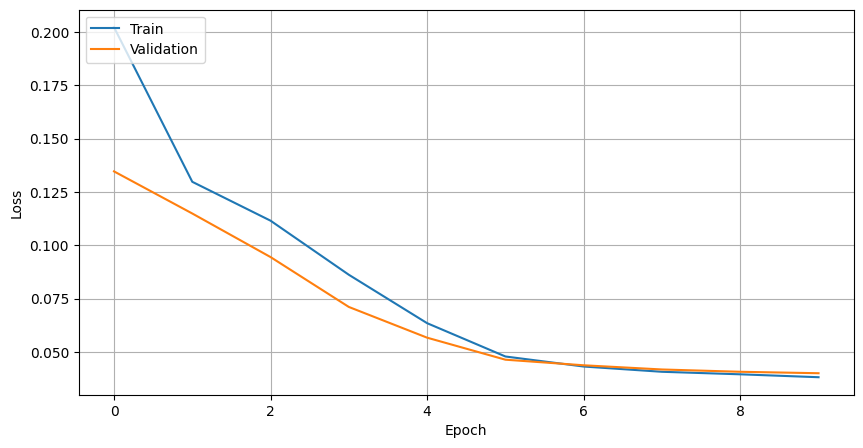

Classification training results:


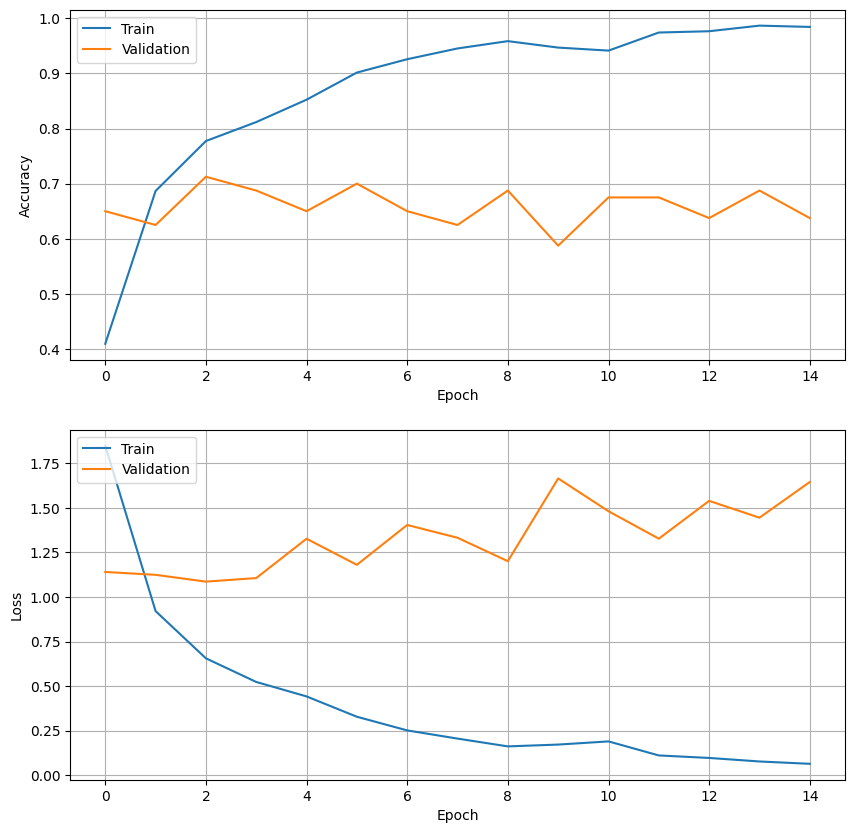

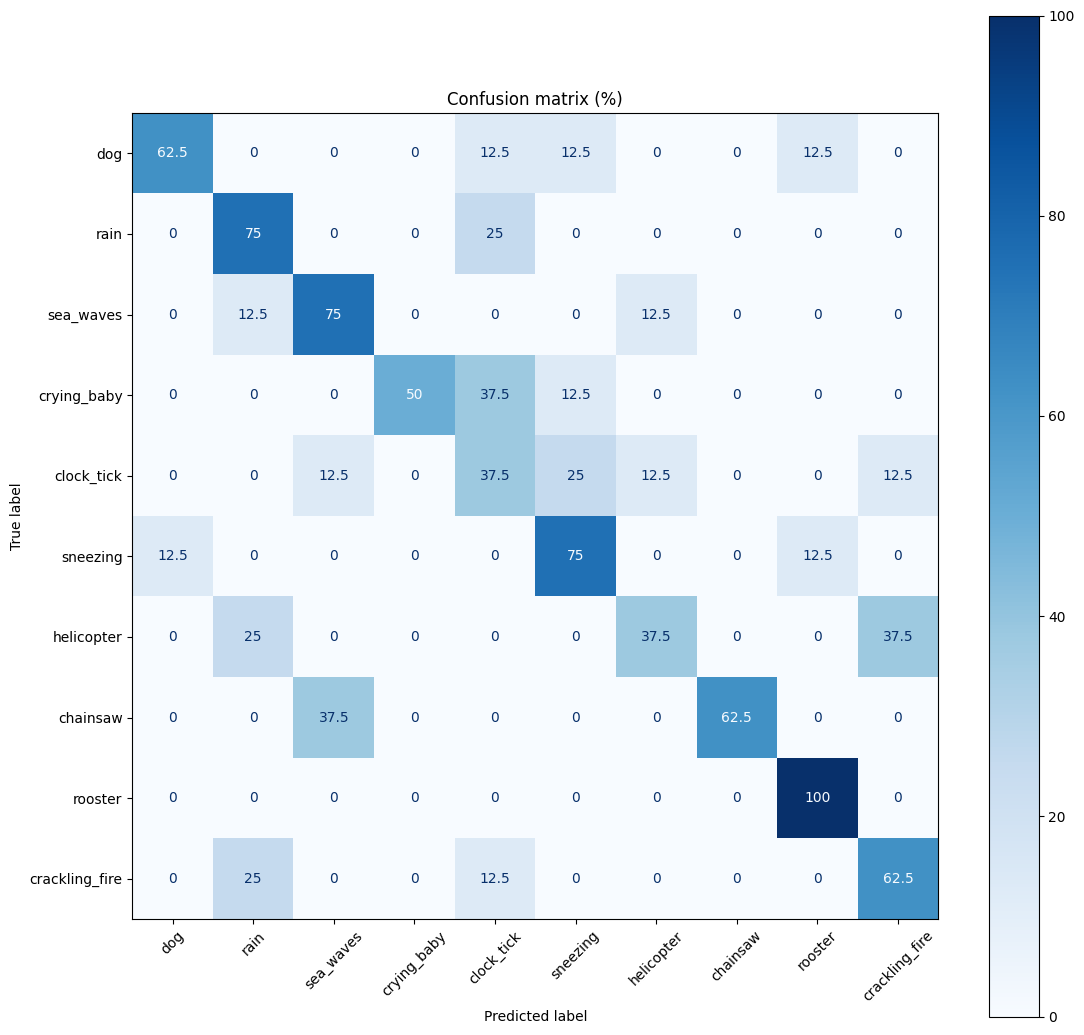

Fold 2/5

Training AE model...

Epoch 1/10
40/40 [==============================] - 53s 1s/step - loss: 0.1997 - val_loss: 0.1344
Epoch 2/10
40/40 [==============================] - 55s 1s/step - loss: 0.1068 - val_loss: 0.0734
Epoch 3/10
40/40 [==============================] - 51s 1s/step - loss: 0.0611 - val_loss: 0.0628
Epoch 4/10
40/40 [==============================] - 49s 1s/step - loss: 0.0539 - val_loss: 0.0560
Epoch 5/10
40/40 [==============================] - 56s 1s/step - loss: 0.0479 - val_loss: 0.0504
Epoch 6/10
40/40 [==============================] - 54s 1s/step - loss: 0.0432 - val_loss: 0.0472
Epoch 7/10
40/40 [==============================] - 47s 1s/step - loss: 0.0407 - val_loss: 0.0453
Epoch 8/10
40/40 [==============================] - 49s 1s/step - loss: 0.0383 - val_loss: 0.0452
Epoch 9/10
40/40 [==============================] - 50s 1s/step - loss: 0.0380 - val_loss: 0.0443
Epoch 10/10
40/40 [==============================] - 48s 1s/step - loss: 0.0357 - val_

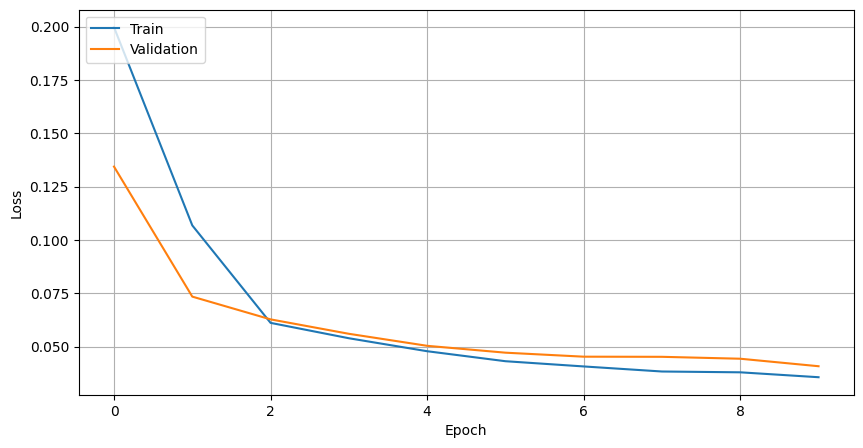

Classification training results:


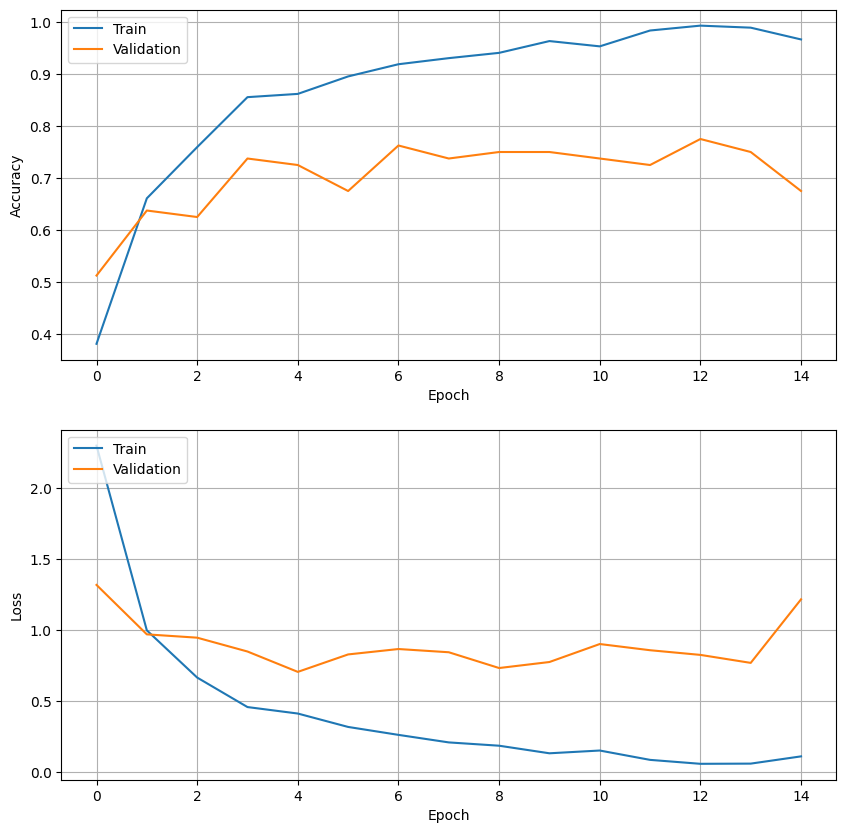

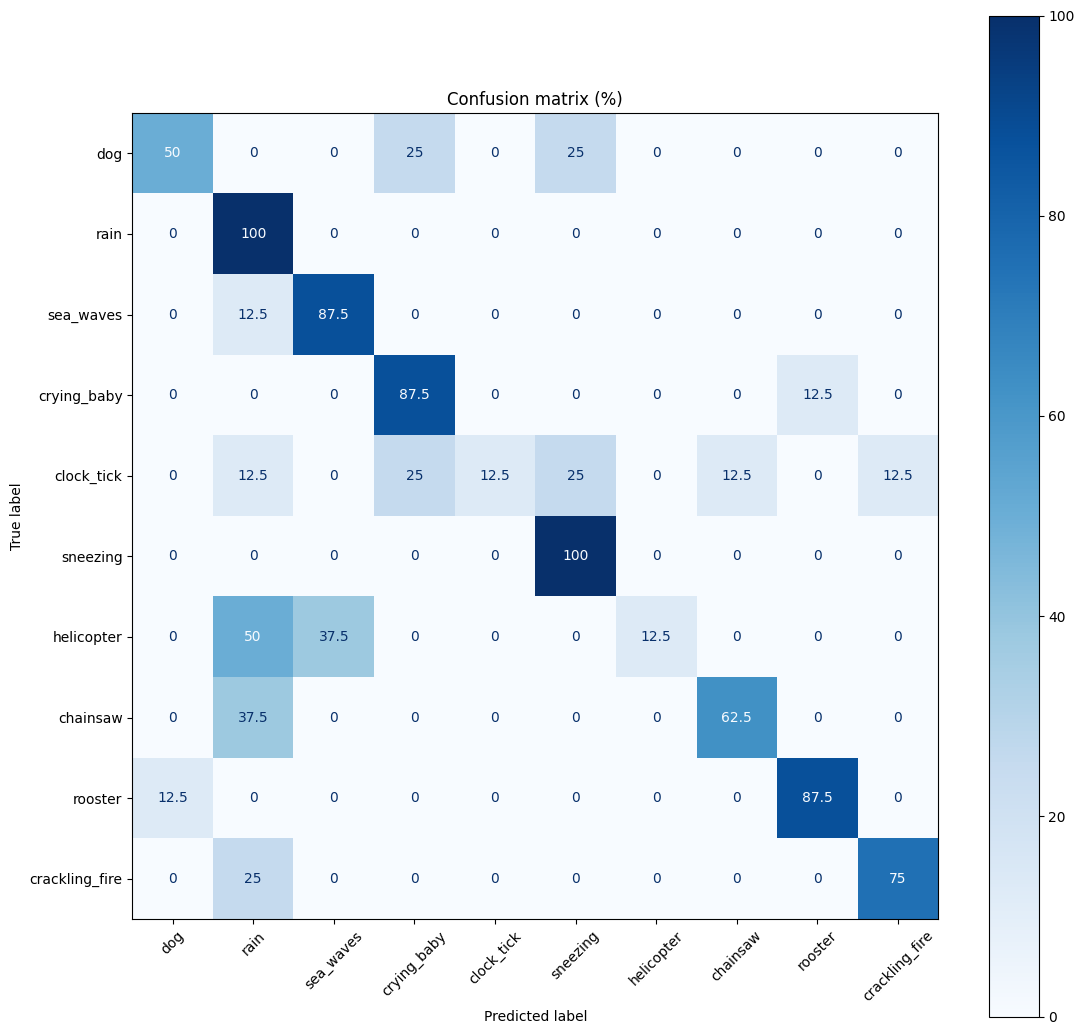

Fold 3/5

Training AE model...

Epoch 1/10
40/40 [==============================] - 53s 1s/step - loss: 0.2049 - val_loss: 0.1434
Epoch 2/10
40/40 [==============================] - 50s 1s/step - loss: 0.1309 - val_loss: 0.1209
Epoch 3/10
40/40 [==============================] - 51s 1s/step - loss: 0.1139 - val_loss: 0.1094
Epoch 4/10
40/40 [==============================] - 52s 1s/step - loss: 0.1012 - val_loss: 0.0967
Epoch 5/10
40/40 [==============================] - 50s 1s/step - loss: 0.0913 - val_loss: 0.0876
Epoch 6/10
40/40 [==============================] - 55s 1s/step - loss: 0.0814 - val_loss: 0.0788
Epoch 7/10
40/40 [==============================] - 54s 1s/step - loss: 0.0654 - val_loss: 0.0502
Epoch 8/10
40/40 [==============================] - 49s 1s/step - loss: 0.0429 - val_loss: 0.0428
Epoch 9/10
40/40 [==============================] - 49s 1s/step - loss: 0.0395 - val_loss: 0.0417
Epoch 10/10
40/40 [==============================] - 49s 1s/step - loss: 0.0387 - val_

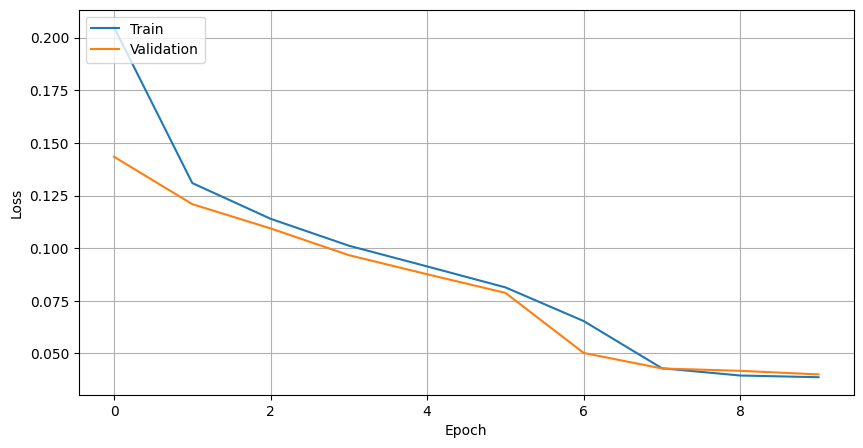

Classification training results:


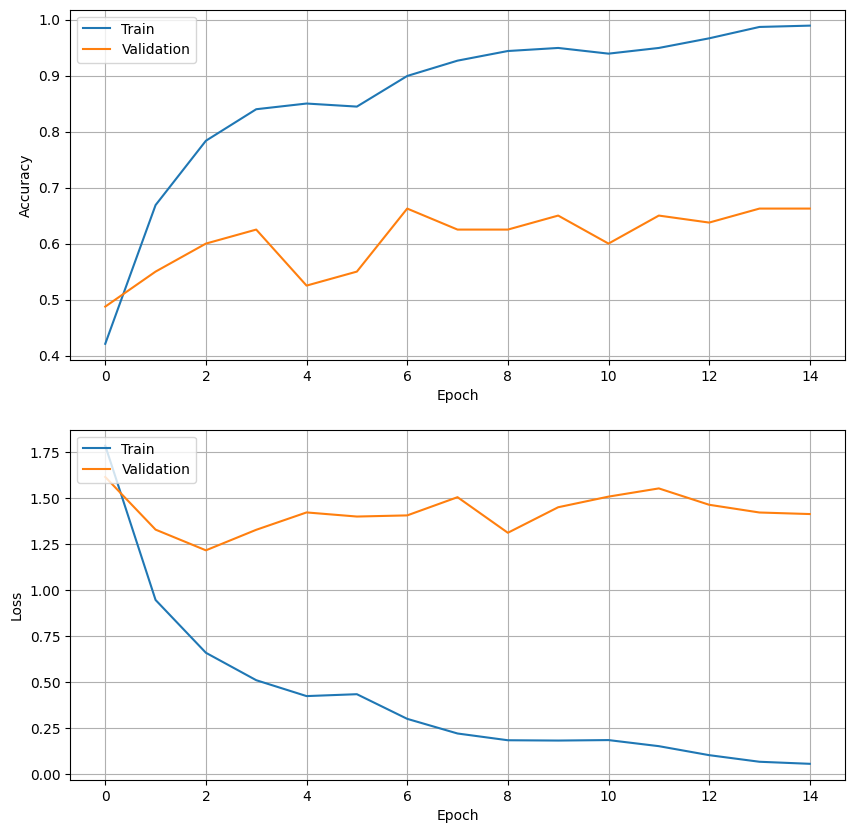

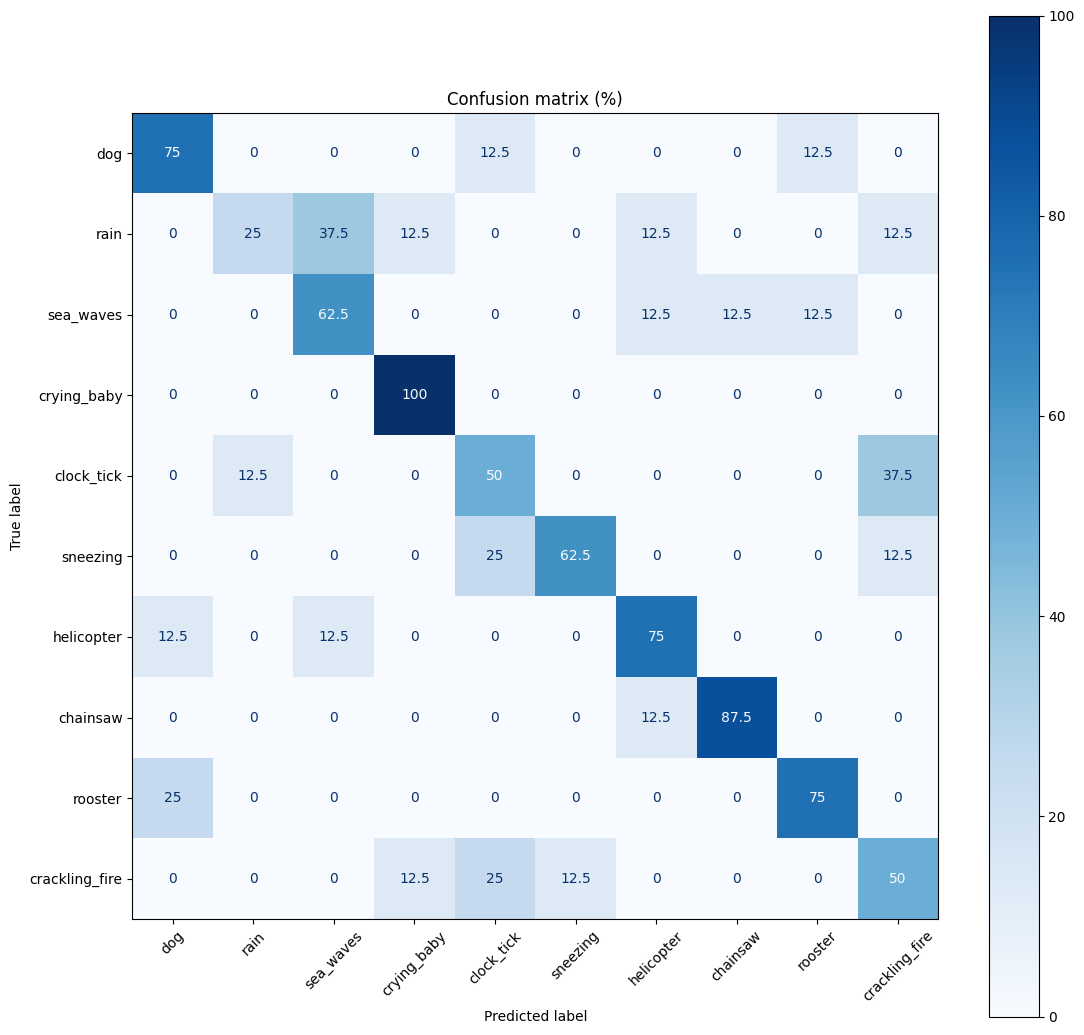

Fold 4/5

Training AE model...

Epoch 1/10
40/40 [==============================] - 58s 1s/step - loss: 0.2247 - val_loss: 0.1369
Epoch 2/10
40/40 [==============================] - 49s 1s/step - loss: 0.1324 - val_loss: 0.1182
Epoch 3/10
40/40 [==============================] - 48s 1s/step - loss: 0.1155 - val_loss: 0.1057
Epoch 4/10
40/40 [==============================] - 55s 1s/step - loss: 0.0941 - val_loss: 0.0655
Epoch 5/10
40/40 [==============================] - 50s 1s/step - loss: 0.0550 - val_loss: 0.0517
Epoch 6/10
40/40 [==============================] - 54s 1s/step - loss: 0.0473 - val_loss: 0.0457
Epoch 7/10
40/40 [==============================] - 51s 1s/step - loss: 0.0426 - val_loss: 0.0419
Epoch 8/10
40/40 [==============================] - 47s 1s/step - loss: 0.0402 - val_loss: 0.0399
Epoch 9/10
40/40 [==============================] - 53s 1s/step - loss: 0.0380 - val_loss: 0.0382
Epoch 10/10
40/40 [==============================] - 54s 1s/step - loss: 0.0368 - val_

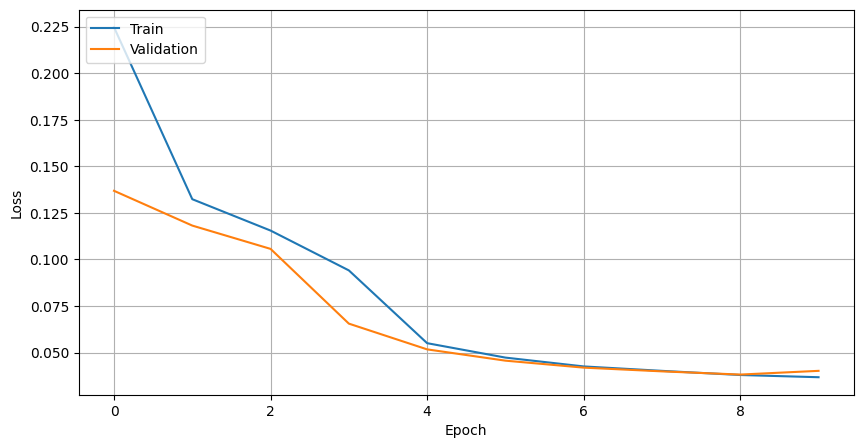

Classification training results:


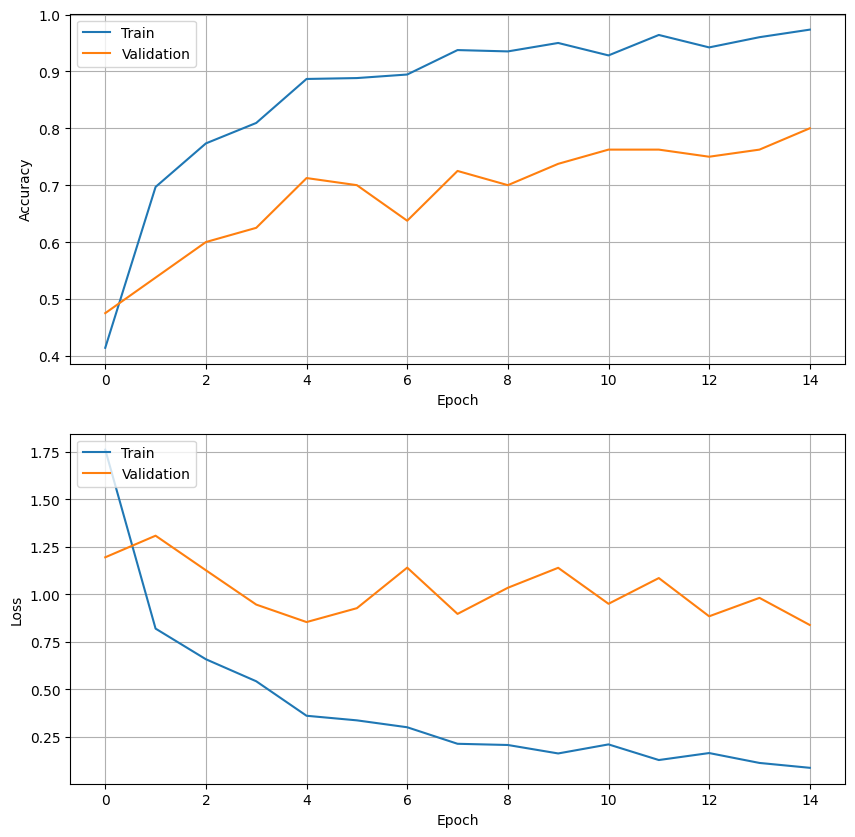

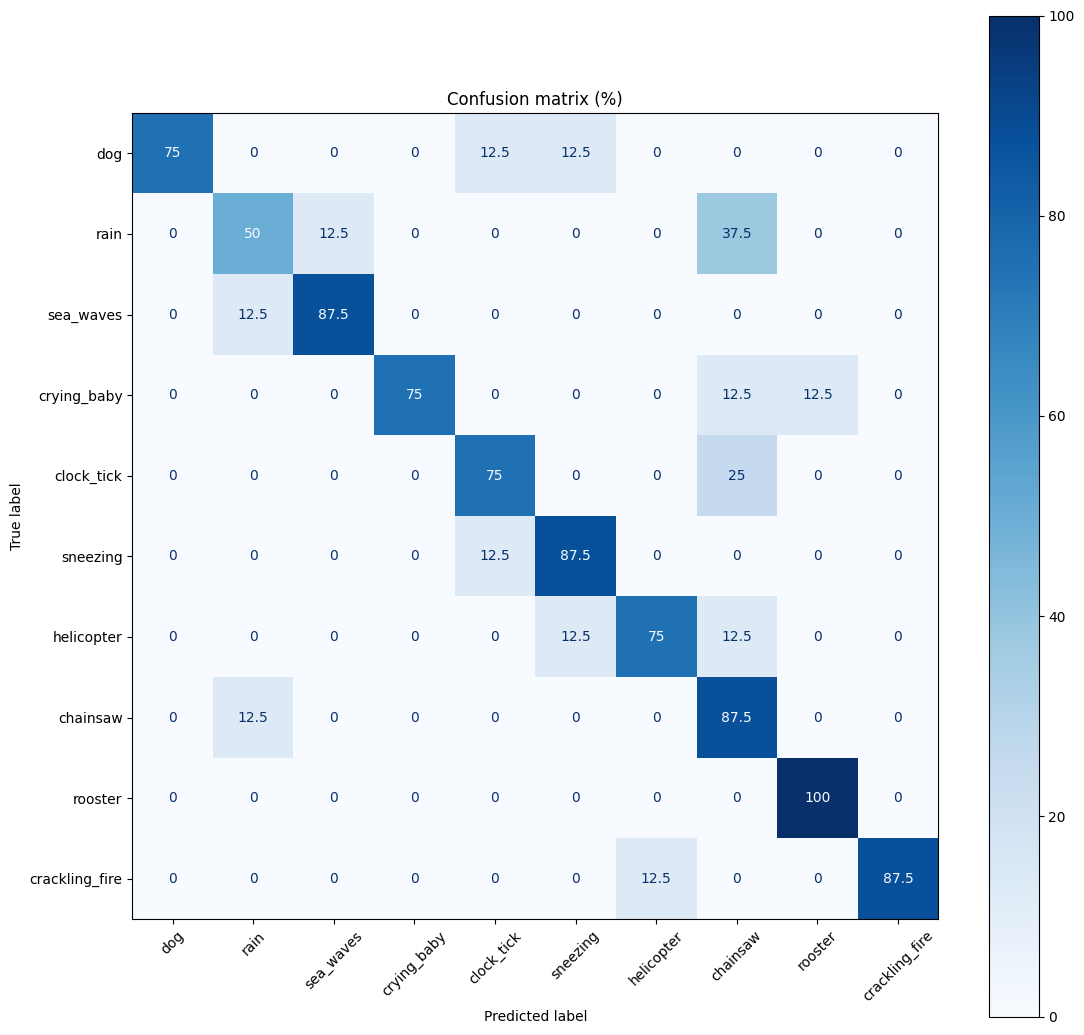

Fold 5/5

Training AE model...

Epoch 1/10
40/40 [==============================] - 55s 1s/step - loss: 0.1968 - val_loss: 0.1393
Epoch 2/10
40/40 [==============================] - 57s 1s/step - loss: 0.1286 - val_loss: 0.1168
Epoch 3/10
40/40 [==============================] - 59s 1s/step - loss: 0.1129 - val_loss: 0.1046
Epoch 4/10
40/40 [==============================] - 50s 1s/step - loss: 0.1006 - val_loss: 0.0935
Epoch 5/10
40/40 [==============================] - 46s 1s/step - loss: 0.0894 - val_loss: 0.0828
Epoch 6/10
40/40 [==============================] - 49s 1s/step - loss: 0.0770 - val_loss: 0.0681
Epoch 7/10
40/40 [==============================] - 52s 1s/step - loss: 0.0540 - val_loss: 0.0472
Epoch 8/10
40/40 [==============================] - 54s 1s/step - loss: 0.0437 - val_loss: 0.0449
Epoch 9/10
40/40 [==============================] - 53s 1s/step - loss: 0.0399 - val_loss: 0.0418
Epoch 10/10
40/40 [==============================] - 50s 1s/step - loss: 0.0381 - val_

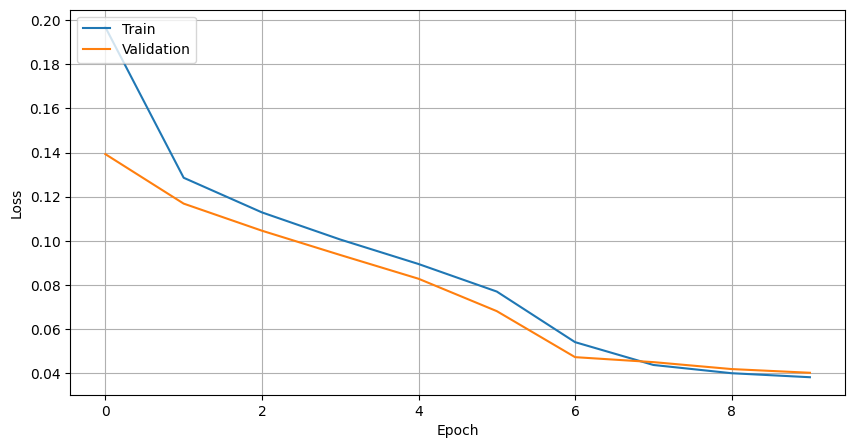

Classification training results:


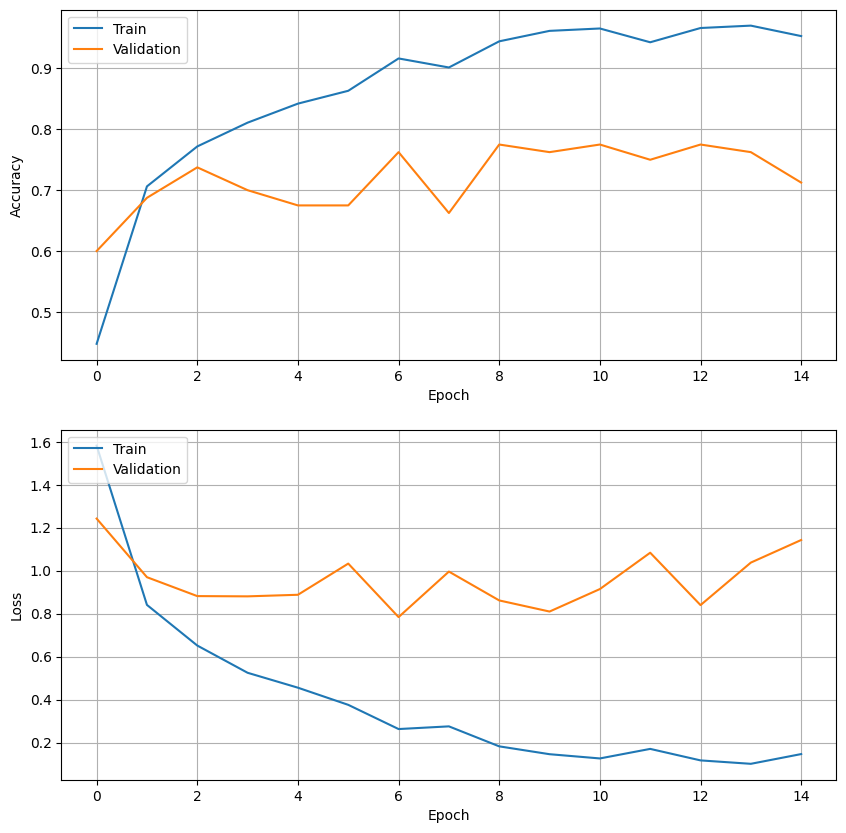

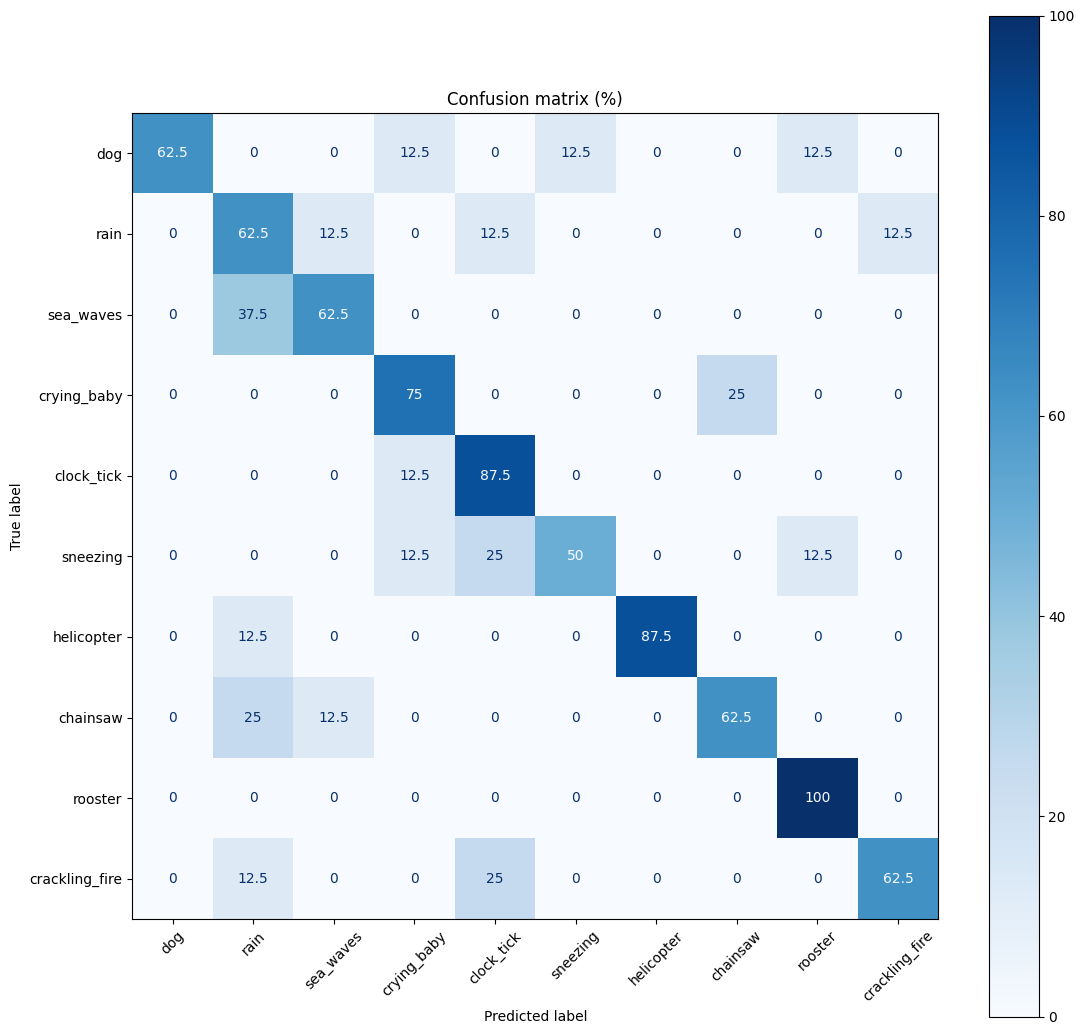

Average results:

AE training results:
Average training loss: 0.037 ± 0.001
Average validation loss: 0.040 ± 0.000

Classification training results:
Average training accuracy: 0.97 ± 0.01
Average validation accuracy: 0.70 ± 0.06
Average training loss: 0.09 ± 0.03
Average validation loss: 1.25 ± 0.27

Average (total) training time: 588.19 ± 7.20 s

Plotting average results:

AE training result plots:


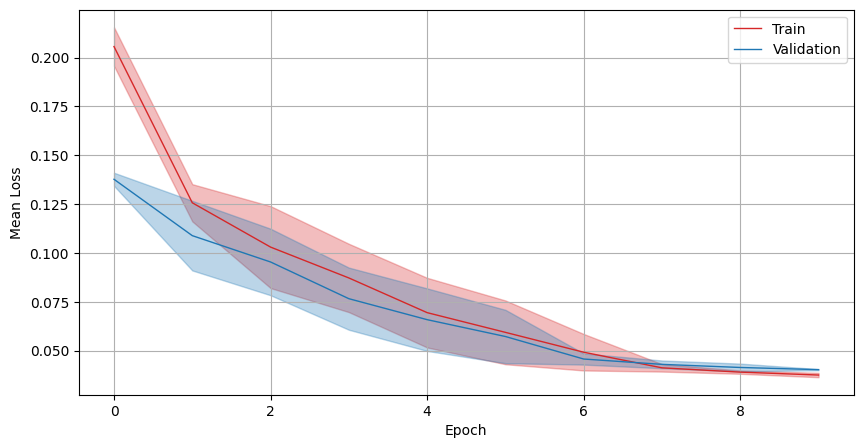

Classification training result plots:


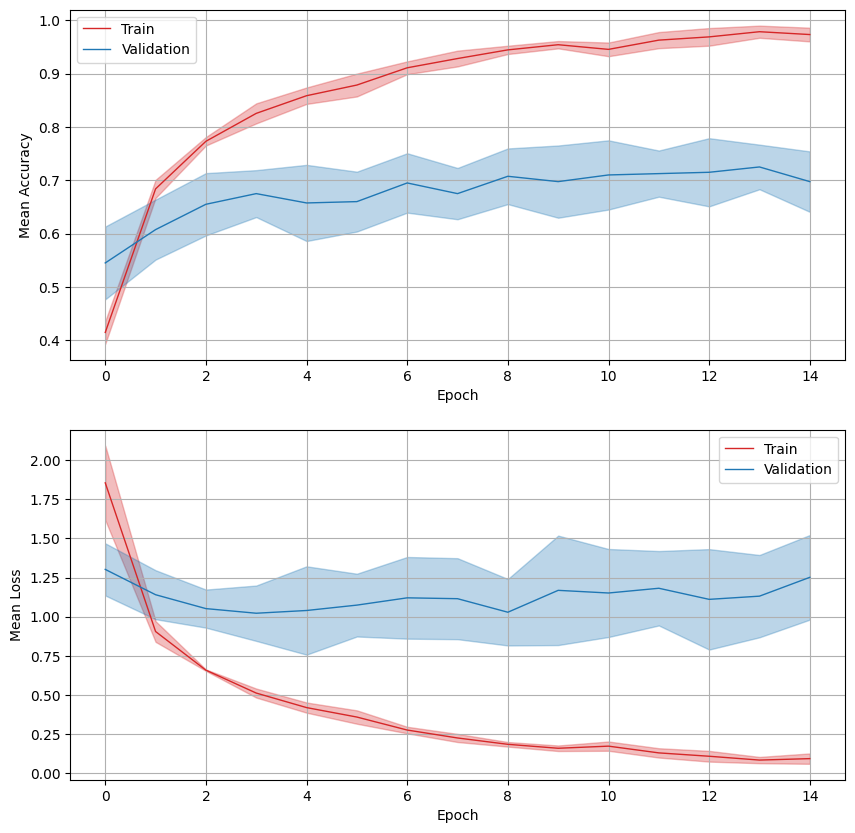

Average confusion matrix:



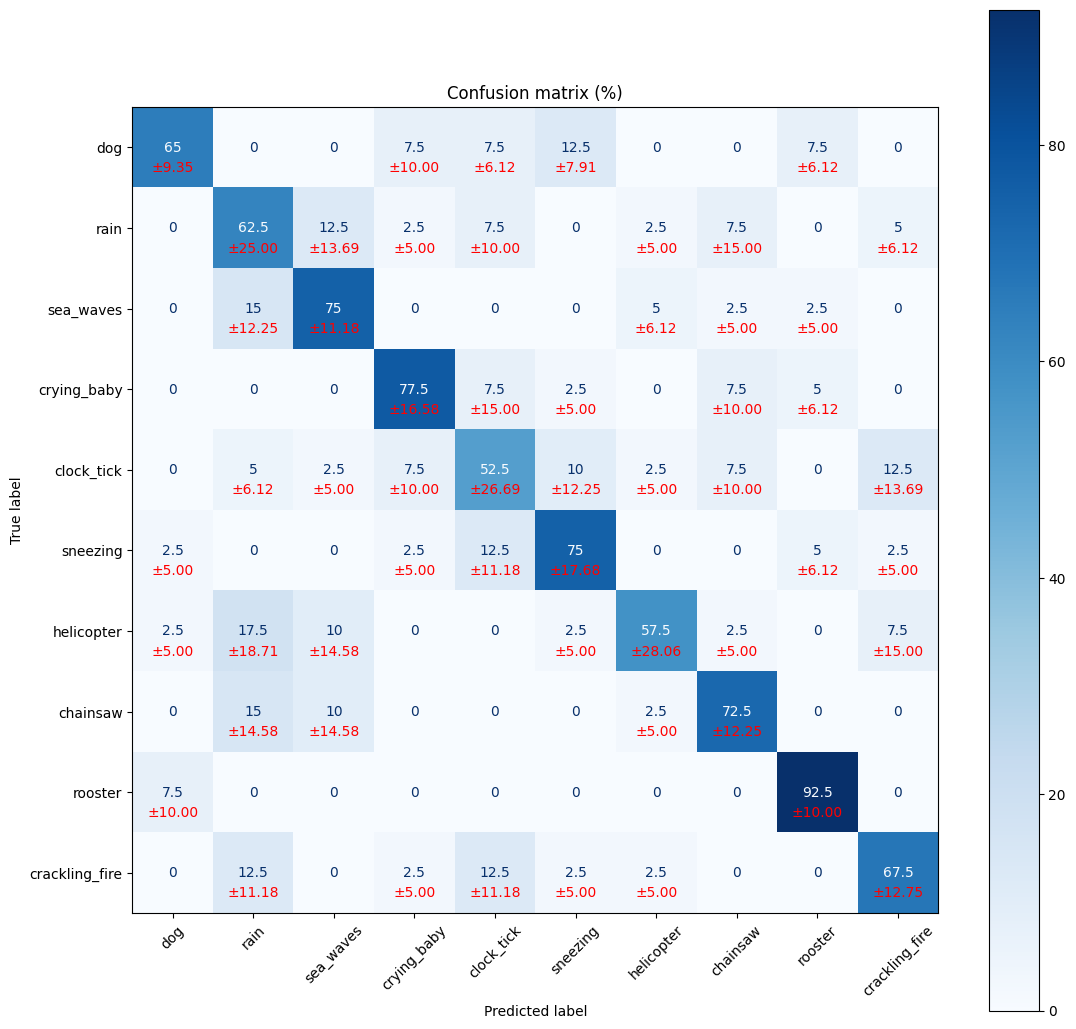

In [5]:
hist = cross_validation(df, 
                        init_model, 
                        X_dim=(128, 156, 1), 
                        n_folds=5, 
                        epochs=15, 
                        num_batch_size=32, 
                        verbose=1,  
                        init_AE = init_autoencoder, 
                        enc_layer = 6,
                        num_epochs_AE=10)

# NB! The function cross_validation is valid also for models without autoencoder. In this case, just ignore the last 3 arguments. (init_AE, enc_layer, num_epochs_AE)